# Plot Eval metrics

In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import joblib
import re
import seaborn as sns
from typing import Callable
# Apply the default theme
sns.set_theme()

import sys

sys.path.append("..")

from src.data.dataloader import PromptLoader, GigawordDataLoader, DailymailDataLoader, TweetQADataLoader, RottenTomatoesDataLoader
from src.utils.eval_metric import eval_gigaword, eval_dailymail, evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative"):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=True)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b"],
    experiment_path=Path("../experiments/"),
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data))
                except:
                    print(f"Error processing {str(f)}")

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

## Evaluate on Rotten Tomatoes

In [12]:
rt = RottenTomatoesDataLoader()

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

## Evaluate on TweetQA

In [4]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()

In [5]:
tq_results = get_results_for_evalset("tweetqa", tq_reference_data)

Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_8
Error processing ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_tweetqa/num_examples_10
Error processing ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_tweetqa/num_examples_6
Error processing ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_tweetqa/num_examples_0
Error processing ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_tweetqa/num_examples_4
Error processing ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_tweetqa/num_examples_2
Error processing ../experiments/mistra

In [6]:
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")
tq_results_df.head()

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples
0,0.280244,0.146540,0.276942,0.277614,0.427295,mistral-7b,dailymail,3
1,0.253151,0.126276,0.249498,0.249865,0.407057,mistral-7b,dailymail,0
2,0.280854,0.145197,0.277830,0.278367,0.425253,mistral-7b,dailymail,4
3,0.284758,0.145439,0.281281,0.281955,0.429017,mistral-7b,dailymail,2
4,0.279857,0.140774,0.276821,0.277383,0.426147,mistral-7b,dailymail,5


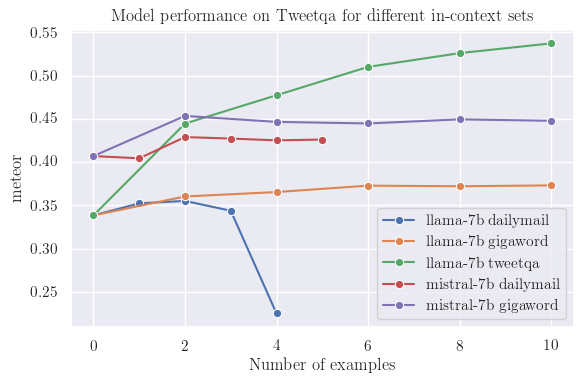

In [8]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot a metric
fig, ax = plt.subplots(figsize=(6, 4))

metric = "meteor"

for (model, inctxt), df in tq_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Tweetqa for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

## Evaluate on Dailymail Set

In [13]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()

Removing large training set examples
Original training set size:  287113
New Training set size:  258269


In [14]:
dm_results = get_results_for_evalset("dailymail", dm_reference_data)

Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_4
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_2
Skipping ../experiments/llama-7b/eval_data_dailymail/incon

In [7]:
# Define paths to experiments, models and evaluation set
EXPERIMENTS_PATH = Path("../experiments")
MODEL_FOLDER_NAMES = ["mistral-7b", "llama-7b"]
EVAL_FOLDER_NAME = "eval_data_dailymail"

# Load the results from the folders
results = []
for model_folder in MODEL_FOLDER_NAMES:
    eval_folder = Path(EXPERIMENTS_PATH / model_folder / EVAL_FOLDER_NAME)
    if not eval_folder.is_dir():
        print(f"Skipping {model_folder} as {EVAL_FOLDER_NAME} not found")
        continue

    # extract results in parallel for each in context set
    for in_ctxt_folder in eval_folder.iterdir():
        res = joblib.Parallel(n_jobs=-1)(
            joblib.delayed(get_results)(f, dm_reference_data) for f in in_ctxt_folder.iterdir()
        )
        # Remove empty results
        res = [r for r in res if r]
        results.extend(res)

Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_4
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_2
Skipping ../experiments/llama-7b/eval_data_dailymail/incon

In [15]:
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.093275,0.003659,0.067799,0.080609,813.963,mistral-7b,dailymail,3
1,0.093800,0.003398,0.069140,0.081556,881.994,mistral-7b,dailymail,6
2,0.091321,0.003619,0.067370,0.078830,778.065,mistral-7b,dailymail,0
3,0.093670,0.003608,0.068678,0.081593,887.419,mistral-7b,dailymail,4
4,0.091731,0.003624,0.067509,0.079617,909.117,mistral-7b,dailymail,2


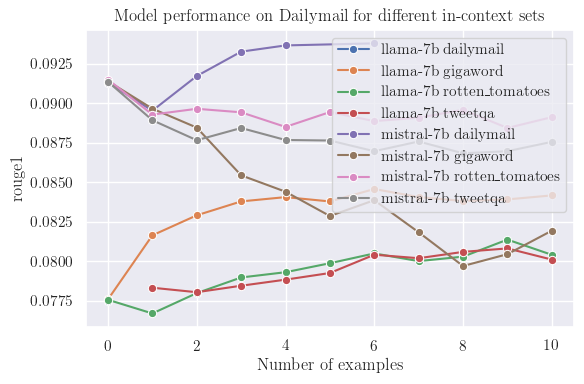

In [16]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot a metric
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge1"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

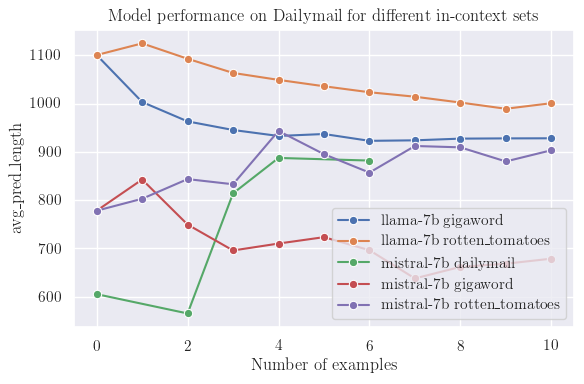

In [14]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "avg_pred_length"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

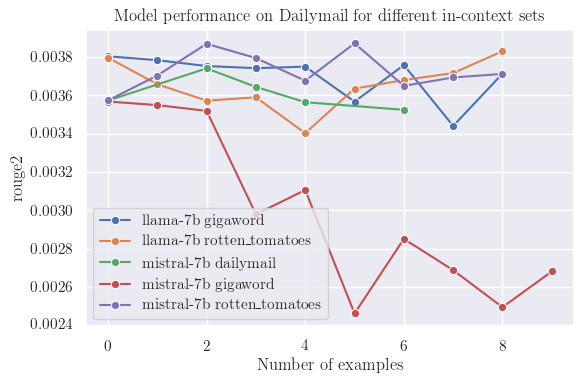

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge2"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

# 1. Gigaword set

In [18]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()

In [19]:
len(gw_reference_data)

1951

In [22]:
fpath = Path("../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_0/iterative/predictions.json")
pred_data = json.load(open(fpath, "r"))
len(pred_data)

1951

In [20]:
gw_results = get_results_for_evalset("gigaword", gw_reference_data)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_16
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_tweetqa/num_examples_0
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_tweetqa/num_examples_1
Skipping ../experiments/mistral-7b/eval_da

In [16]:
# Define paths to experiments, models and evaluation set
EXPERIMENTS_PATH = Path("../experiments")
MODEL_FOLDER_NAMES = ["mistral-7b", "llama-7b"]
EVAL_FOLDER_NAME = "eval_data_gigaword"

In [8]:


# Load the results from the folders
results = []
for model_folder in MODEL_FOLDER_NAMES:
    eval_folder = Path(EXPERIMENTS_PATH / model_folder / EVAL_FOLDER_NAME)
    if not eval_folder.is_dir():
        print(f"Skipping {model_folder} as {EVAL_FOLDER_NAME} not found")
        continue

    # extract results in parallel for each in context set
    for in_ctxt_folder in eval_folder.iterdir():
        res = joblib.Parallel(n_jobs=-1)(
            joblib.delayed(get_results)(f, all_reference_data, eval_gigaword) for f in in_ctxt_folder.iterdir()
        )
        # Remove empty results
        res = [r for r in res if r]
        results.extend(res)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_16
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_4
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/in

In [21]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))
gw_results_df.head()

48


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.208213,0.064083,0.180833,0.180889,176.746797,mistral-7b,dailymail,3
1,0.185710,0.051803,0.158150,0.158175,203.721681,mistral-7b,dailymail,0
2,0.209812,0.065090,0.182366,0.182388,172.145054,mistral-7b,dailymail,4
3,0.206521,0.064153,0.178752,0.178984,177.343414,mistral-7b,dailymail,2
4,0.211279,0.066320,0.183826,0.183797,169.700666,mistral-7b,dailymail,5


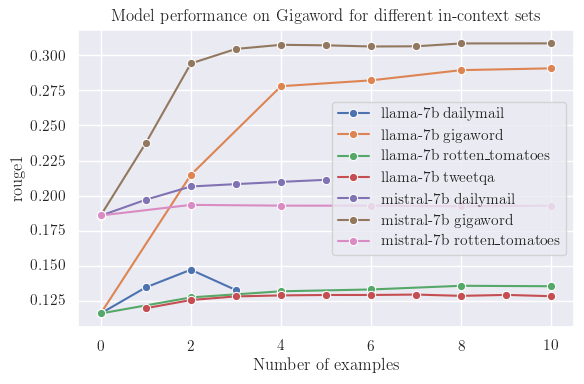

In [22]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))
metric = "rouge1"

for (model, inctxt), df in gw_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

In [9]:
# convert to dataframe
results_df = pd.DataFrame.from_records(results)
# df = df.sort_values("num_examples")
results_df.head()

,rouge1,rouge2,rougeL,rougeLsum,num_examples,incontext_set,model,avg_pred_length
0,0.206175,0.062640,0.178556,0.178640,3,dailymail,mistral-7b,176.392619
1,0.186084,0.051977,0.158072,0.158119,0,dailymail,mistral-7b,203.422860
2,0.204587,0.062598,0.177081,0.177035,2,dailymail,mistral-7b,180.579190
3,0.195708,0.059174,0.169372,0.169331,1,dailymail,mistral-7b,198.410559
4,0.192841,0.056026,0.165034,0.164829,10,rotten_tomatoes,mistral-7b,190.120964


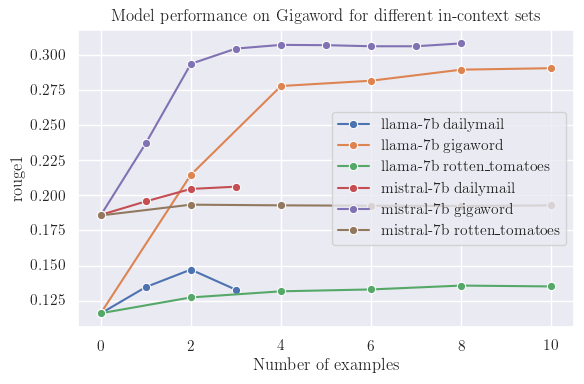

In [10]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))
metric = "rouge1"

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

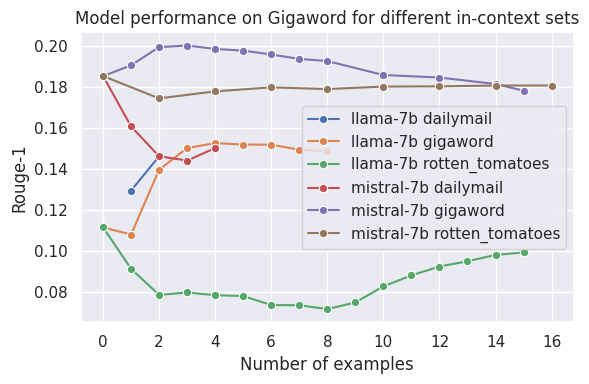

In [13]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

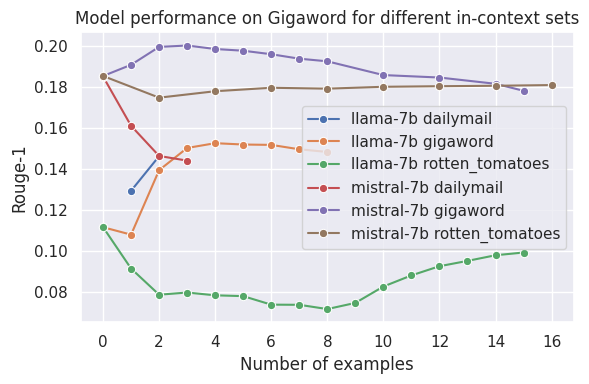

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

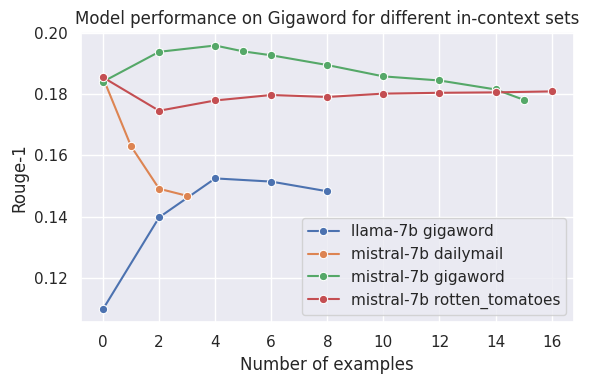

In [6]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

.idea

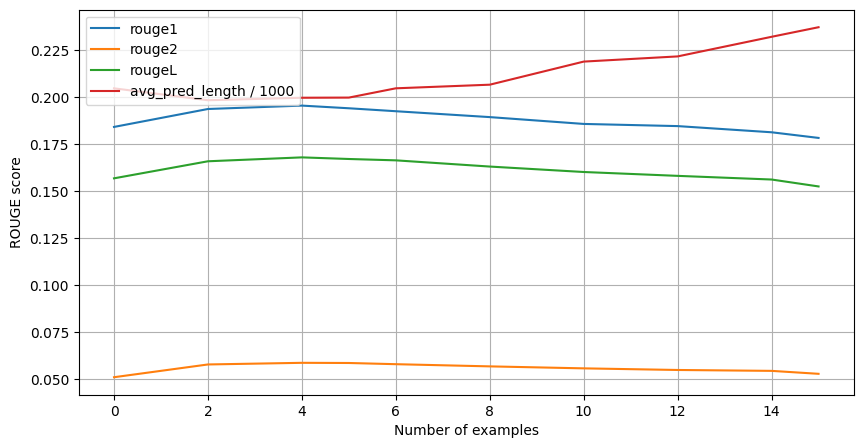

In [56]:
# Plot the results

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["num_examples"], df["rouge1"], label="rouge1")
ax.plot(df["num_examples"], df["rouge2"], label="rouge2")
ax.plot(df["num_examples"], df["rougeL"], label="rougeL")
ax.plot(df["num_examples"], df["avg_pred_length"] / 1000, label="avg_pred_length / 1000")
ax.set_xlabel("Number of examples")
ax.set_ylabel("ROUGE score")
ax.legend()
ax.grid()
fig.savefig("gigaword.png")
plt.show()

In [43]:
predictions_4 = json.load(open(dataset_folder / "num_examples_4" / "predictions.json"))
predictions_15 = json.load(open(dataset_folder / "num_examples_15" / "predictions.json"))

In [44]:
print(sum([len(s) for s in predictions_4]))
print(sum([len(s) for s in predictions_15]))


389669
462917


In [46]:
predictions_4[1]

'The Sri Lankan government announced the closure of government schools in the north of the country on Wednesday due to an escalating military campaign against Tamil separatists.'

### Test evaluate

In [ ]:
pred_path = "/home/ag2118/rds/hpc-work/inctxt/inctxt/experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/predictions.json"

eval_idxs_file = Path(pred_path).parent / "eval_idxs.json"
if eval_idxs_file.is_file():
    ref_data = [dm_reference_data[i] for i in json.load(open(eval_idxs_file))]
else:
    ref_data = dm_reference_data
evaluate(pred_path, ref_data, use_cached=True)